In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import AlignIO
import torch
import torch.nn as nn

In [185]:
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22, 'B': 23}
AA_ALPHABETS = "ACDEFGHIKLMNPQRSTVWY-"
MAX_INDEX = 20
NUM_CLASSES = MAX_INDEX + 1
GAP_THRESHOLD = 0.95

# def numeric_encode(seq, max_index=None):
#     seq_numeric = np.array([aa1_to_index[aa] for aa in str(seq).upper().replace('.', '-')])
#     if max_index is not None:
#         seq_numeric[seq_numeric > max_index] = max_index
#     return torch.from_numpy(seq_numeric)
    

# def filter_gaps(index_seqs, gap_index, threshold=0.9):
#     N = index_seqs.shape[0]
#     gap_pos = torch.sum(index_seqs == gap_index, dim=0) > threshold * N
#     filtered_sequences = index_seqs[:, ~gap_pos]
#     return filtered_sequences

def encode_msa2onehot(path):
    with open(path, 'r') as f:
        alignment = AlignIO.read(path, 'fasta')
    
    encoded_sequences = {}
    for record in alignment:
        x_numeric = numeric_encode(record.seq, max_index=MAX_INDEX)
        x_one_hot = nn.functional.one_hot(x_numeric.long(), NUM_CLASSES).float() # [N, L, C]
        encoded_sequences[record.id] = x_one_hot

    return encoded_sequences

In [75]:
def calculate_pssm(data):
    freqs = torch.sum(data, dim=0)
    probs = freqs / torch.sum(freqs, dim=1, keepdims=True)
    probs = probs.detach().cpu().numpy()
    return probs


def plot_pssm(passm, title=''):
    # pssm: [C, L]
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(pssm.T)
    plt.title(f'PSSM for {title}')
    plt.xlabel('Position in Sequence')
    plt.ylabel('Amino Acid')
    ax.set_yticks(np.arange(NUM_CLASSES) + 0.5)
    ax.set_yticklabels(list(AA_ALPHABETS), rotation=0)

# Load Data

In [182]:
clade = 'AGO'
msa_path = f'/home/moon/projects/AgoAnalysis/msa/{clade}.msa.fasta'
msa2onehot = encode_msa2onehot(msa_path)
msas = torch.stack(list(msa2onehot.values()))
pssm = calculate_pssm(msas)

# PSSM Heatmap

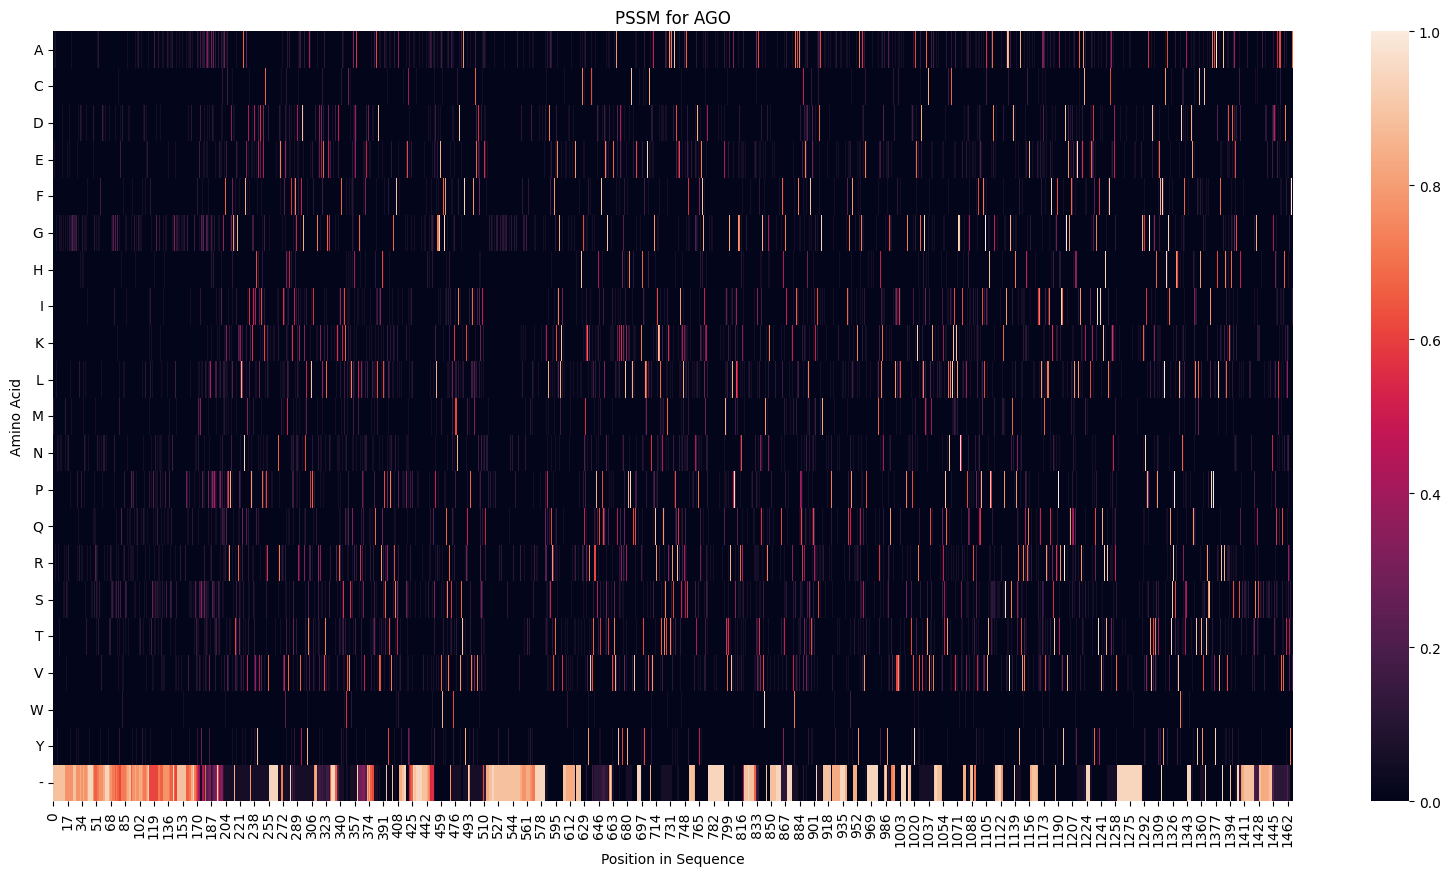

In [12]:
plot_pssm(pssm, f'{clade}')

# pssm_outpath = f'/home/moon/projects/AgoAnalysis/msa/{clade}.msa.pssm.png'
# plt.savefig(pssm_outpath)
plt.show()

In [ ]:
from bokeh.palettes import viridis, RdBu
from bokeh.transform import linear_cmap
from bokeh.plotting import figure, show, output_file, save

def pssm_to_dataframe(pssm, esm_alphabet):
  sequence_length = pssm.shape[0]
  idx = [str(i) for i in np.arange(1, sequence_length + 1)]
  df = pd.DataFrame(pssm, index=idx, columns=list(esm_alphabet))
  df = df.stack().reset_index()
  df.columns = ['Position', 'Amino Acid', 'Probability']
  return df

pssm = calculate_pssm(msas)
df = pssm_to_dataframe(pssm, AA_ALPHABETS)

N = pssm.shape[0]

# plot pssm
num_colors = 256  # You can adjust this number
palette = viridis(256)
TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"
p = figure(title="CONSERVATION",
           x_range=[str(x) for x in range(1,N)],
           y_range=list(AA_ALPHABETS)[::-1],
           width=900, height=400,
           tools=TOOLS, toolbar_location='below',
           tooltips=[('Position', '@Position'), ('Amino Acid', '@{Amino Acid}'), ('Probability', '@Probability')])

r = p.rect(x="Position", y="Amino Acid", width=1, height=1, source=df,
           fill_color=linear_cmap('Probability', palette, low=0, high=1),
           line_color=None)
p.xaxis.visible = False  # Hide the x-axis
# show(p)

output_file(f"/home/moon/projects/AgoAnalysis/msa/{clade}.msa.pssm.html")
save(p)

# PSSM Plot

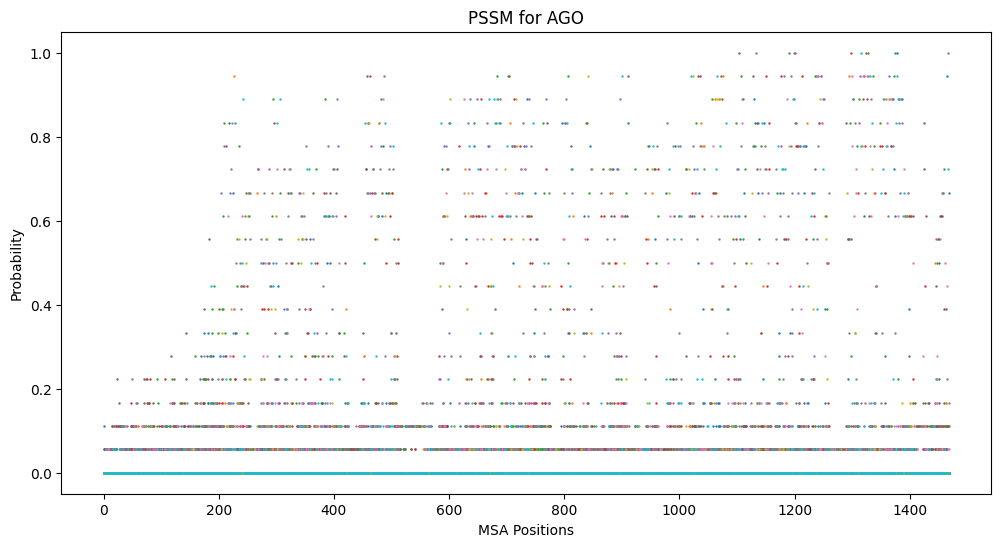

In [76]:
clade = 'AGO'
msa_path = f'/home/moon/projects/AgoAnalysis/msa/{clade}.msa.fasta'
msa2onehot = encode_msa2onehot(msa_path)
msas = torch.stack(list(msa2onehot.values()))
pssm = calculate_pssm(msas)
plt.figure(figsize=[12, 6])
for i in range(20):
    y = pssm.T[i]
    x = range(len(y))
    plt.scatter(x, y, s=0.5)
plt.title(f'PSSM for {clade}')
plt.xlabel('MSA Positions')
plt.ylabel('Probability')
plt.show()

# Logomaker

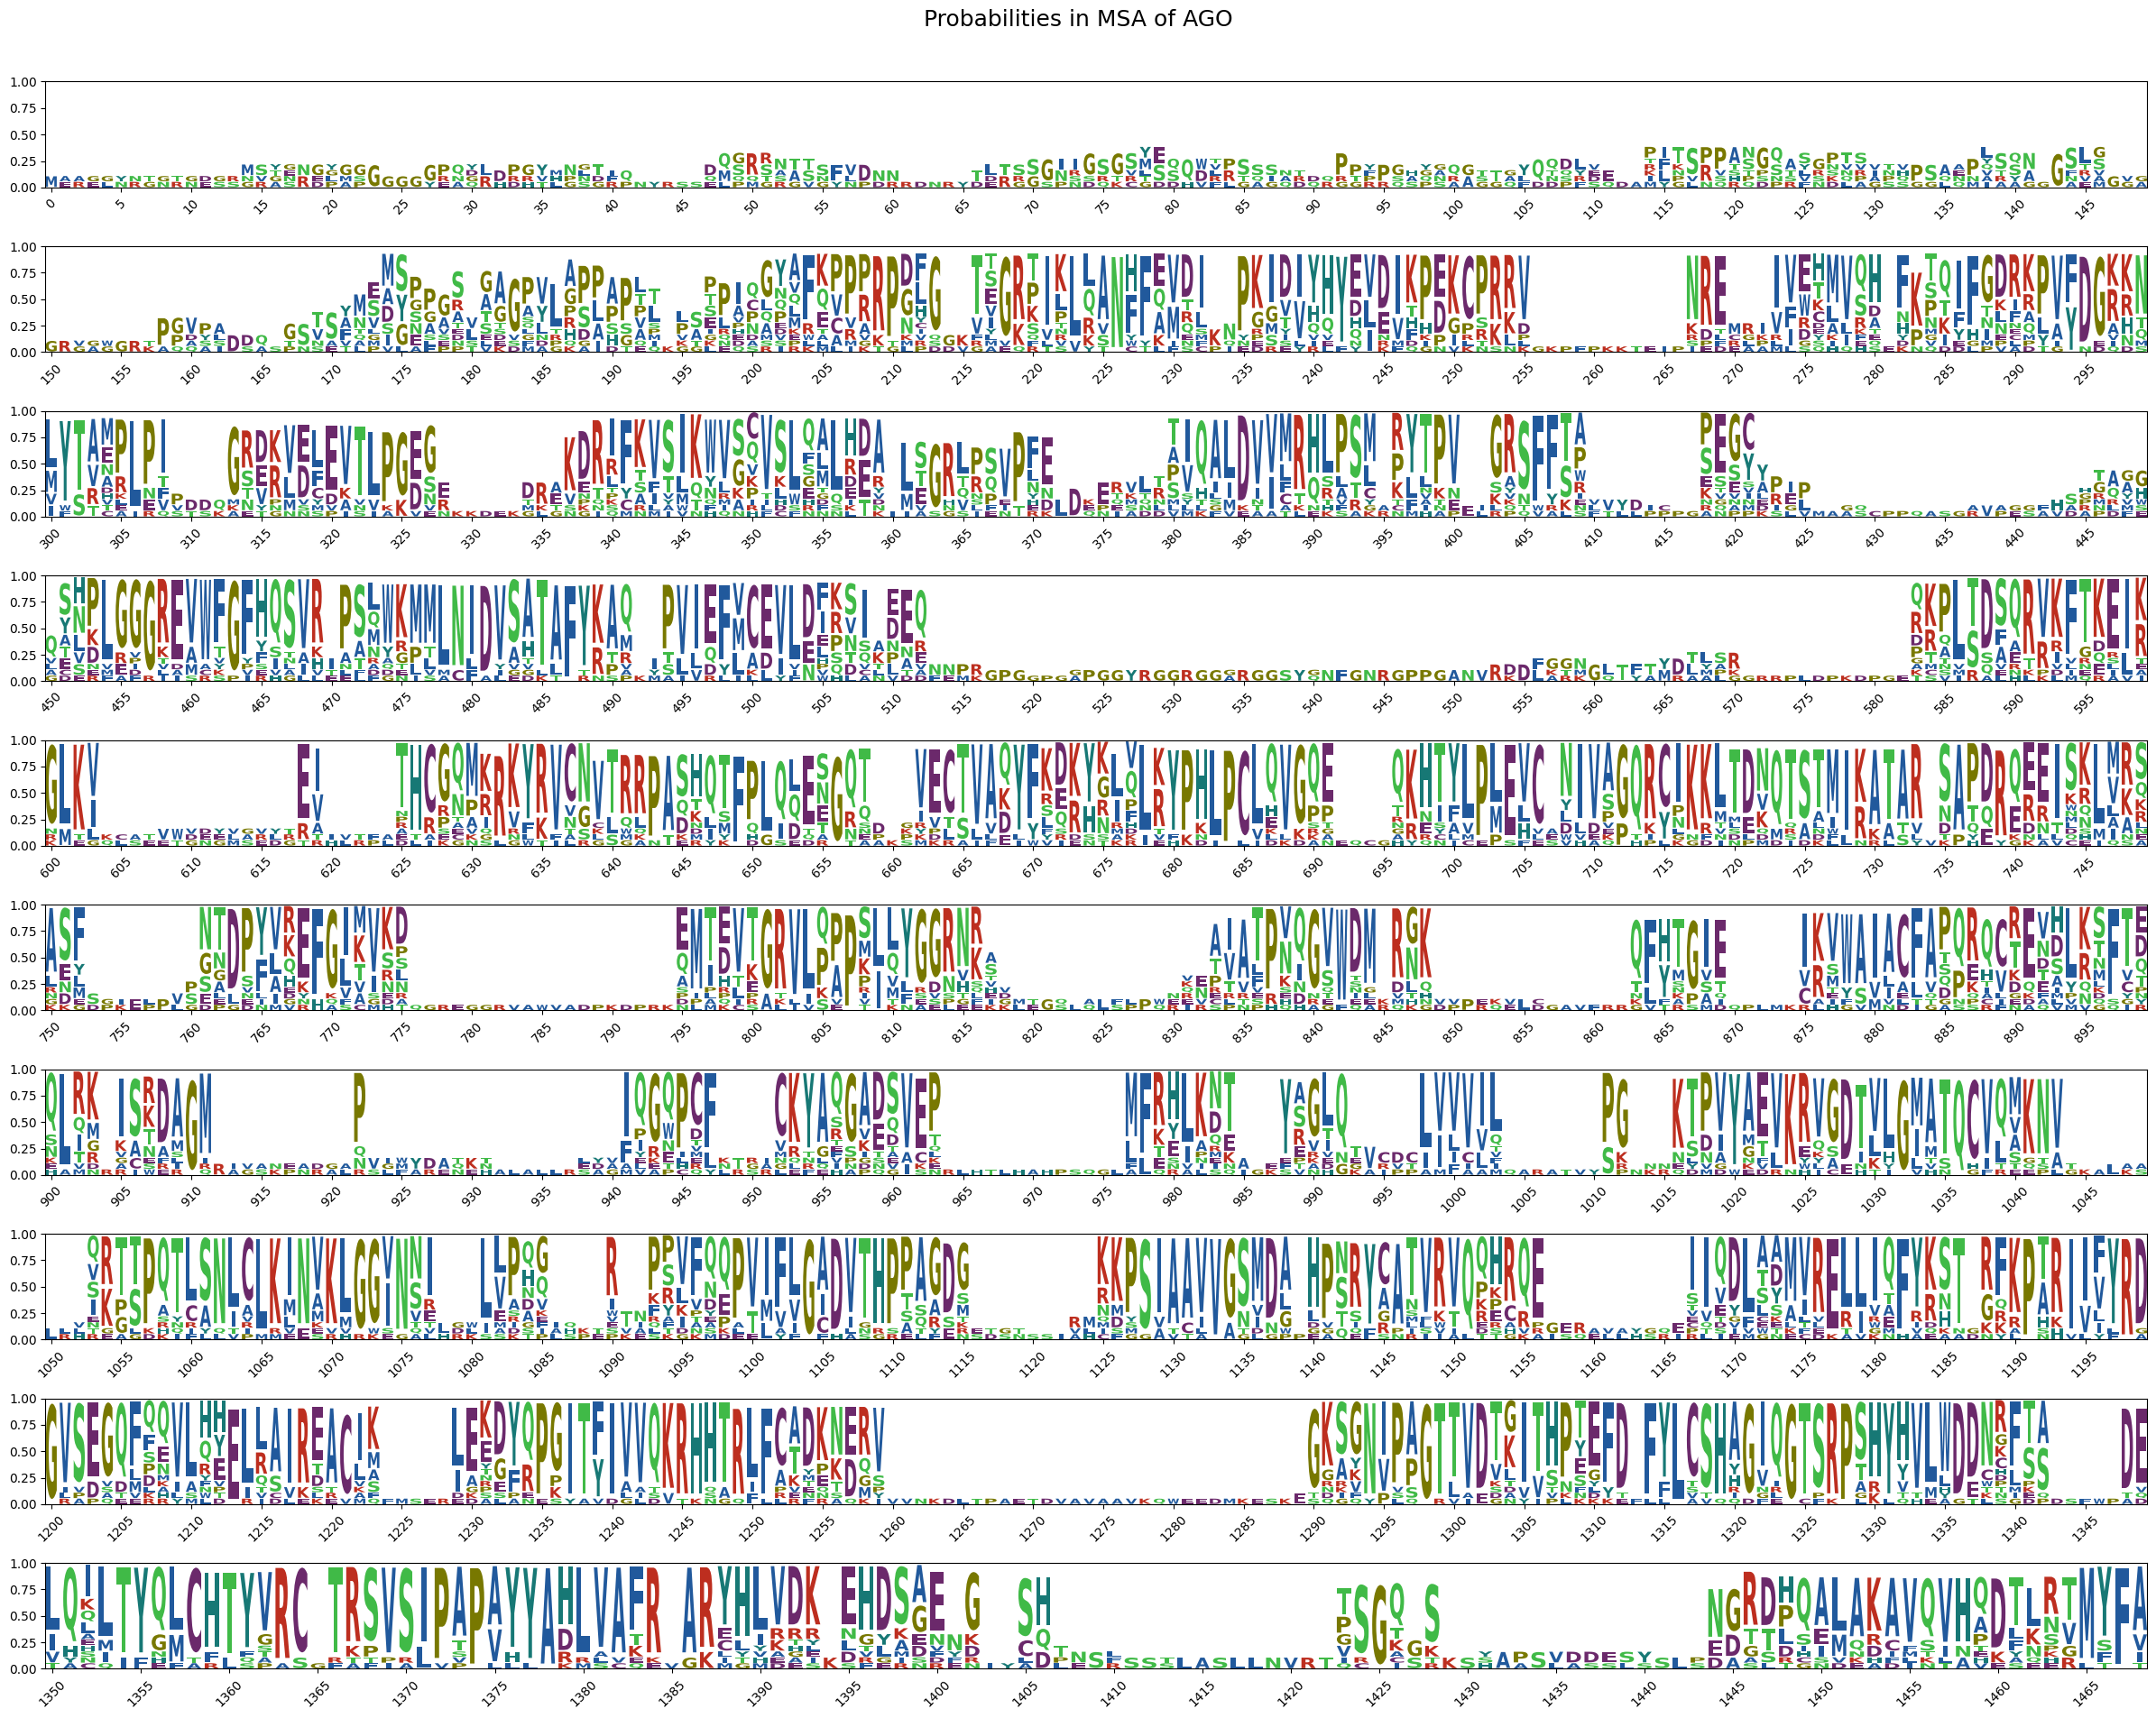

In [183]:
import logomaker

### Probabilities

pssm_df = pd.DataFrame(pssm, columns=list(AA_ALPHABETS))

L = len(pssm_df)
l = 150
num_rows = L // l + 1

fig, axs = plt.subplots(num_rows, 1, figsize=(24, 2*num_rows))

for i in range(num_rows):
    pssm_logo = logomaker.Logo(
        pssm_df.iloc[(i)*l:(i+1)*l, 0:20],         
        color_scheme='NajafabadiEtAl2017',
        vpad=.1, width=.8, ax=axs[i])
    pssm_logo.style_xticks(anchor=0, spacing=5, rotation=45)
    pssm_logo.ax.set_ylim([0, 1])



plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.suptitle(f'Probabilities in MSA of {clade}', fontsize=18)

plt.savefig(f'/home/moon/projects/AgoAnalysis/msa/{clade}.msa.pssm_logo.png')
plt.show()

# pssm_logo.highlight_position(p=4, color='gold', alpha=.5)
# pssm_logo.highlight_position(p=26, color='gold', alpha=.5)

# style using Axes methods
# pssm_logo.ax.set_ylabel('information (bits)')
# pssm_logo.ax.set_xlim([-1, len(ww_df)])

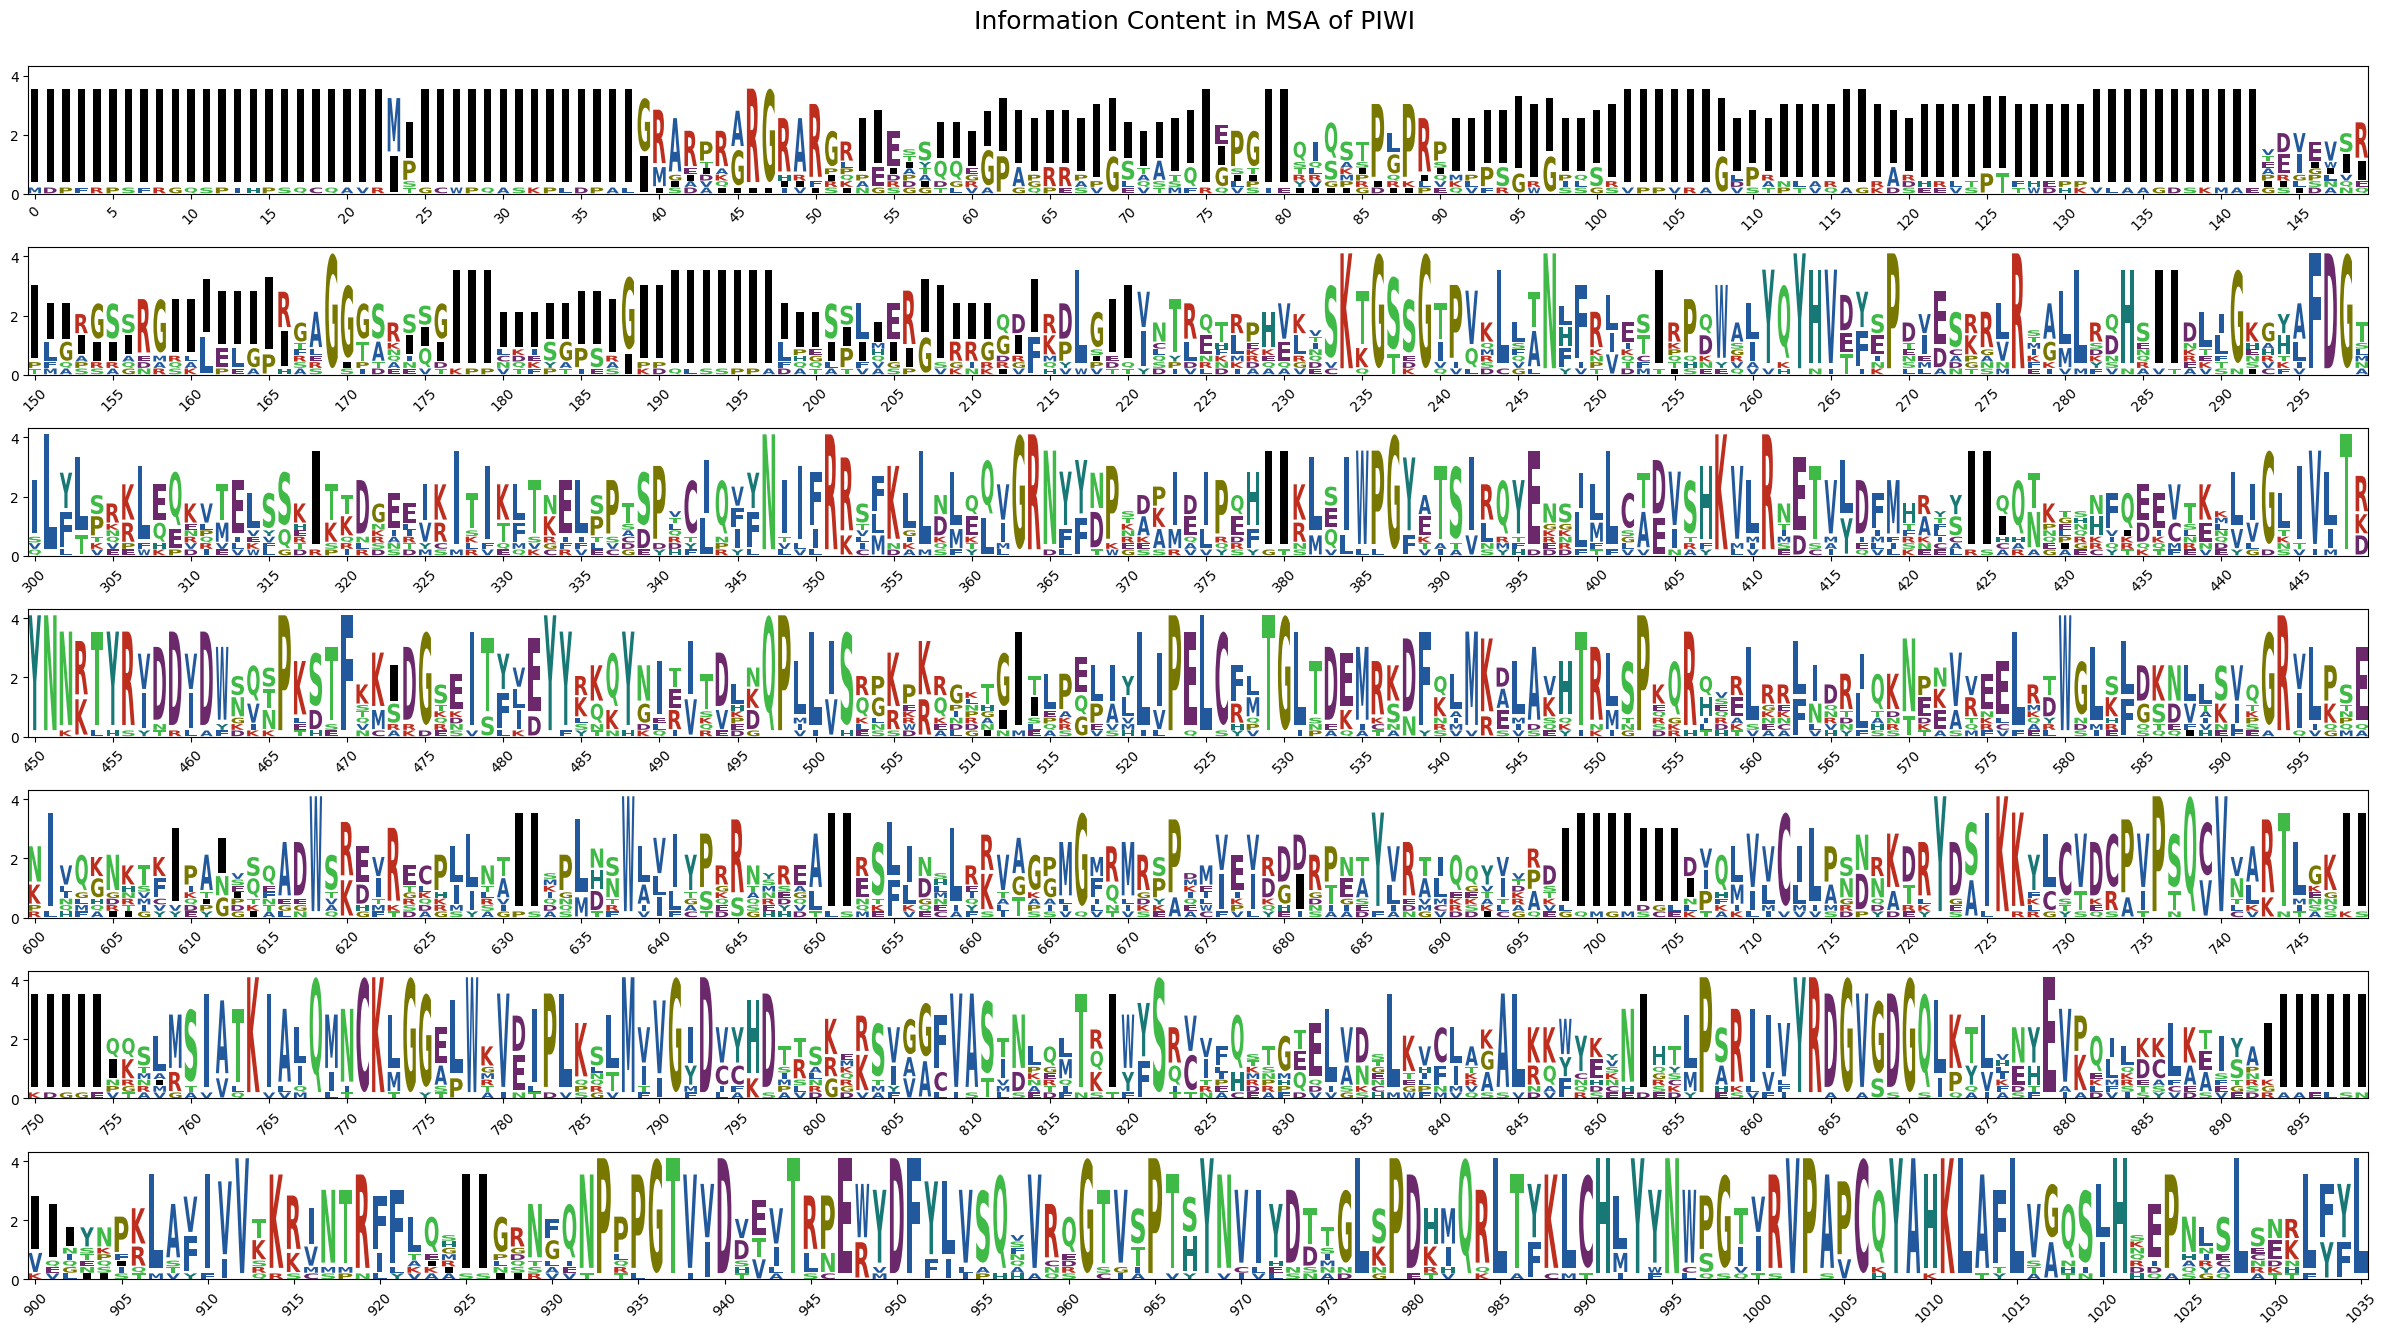

In [179]:
### Information

pssm_df = pd.DataFrame(pssm, columns=list(AA_ALPHABETS))
# background_dict = (pssm_df.sum(axis=0)/len(pssm_df)).to_dict()
background_dict = {aa: 1/20 for aa in AA_ALPHABETS}
ic_df = calculate_information_content(pssm_df, background_dict)

L = len(pssm_df)
l = 150
num_rows = L // l + 1

fig, axs = plt.subplots(num_rows, 1, figsize=(24, 2*num_rows))

ylim = ic_df.max().max()

for i in range(num_rows):
    ic_logo = logomaker.Logo(
        ic_df.iloc[(i)*l:(i+1)*l, 0:21],         
        color_scheme='NajafabadiEtAl2017',
        vpad=.1, width=.8, ax=axs[i])
    ic_logo.style_xticks(anchor=0, spacing=5, rotation=45)
    ic_logo.ax.set_ylim([0, ylim])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f'Information Content in MSA of {clade}', fontsize=18)

# fig.text(0.5, 0.04, 'Positions', ha='center', va='center', fontsize=12)
# fig.text(0.04, 0.5, 'Information Content (bits)', ha='center', va='center', rotation='vertical', fontsize=12)

plt.savefig(f'/home/moon/projects/AgoAnalysis/msa/{clade}.msa.info_logo.png')
plt.show()